In [1]:
import numpy as np
from acv_explainers import ACXplainer
from acv_explainers.utils import *
from sklearn.linear_model import LogisticRegression
from utils import DatasetHelper, DATASETS_NAME
from sklearn.metrics import roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Load FICO dataset

GAMMA = 1.0
dataset = 'h'
dataset_name = DATASETS_NAME[dataset]
model= 'X'

np.random.seed(0)
LAMBDA = 0.01
GAMMA = 1.0

D = DatasetHelper(dataset=dataset, feature_prefix_index=False)

for i in range(len(D.feature_names)):
    D.feature_names[i] = D.feature_names[i].replace(" ", "")
    
columns_names = D.feature_names
columns_id = {}
for i, col in enumerate(columns_names):
    columns_id[col] = i
columns_id

    
print('# Demonstration:', D.dataset_fullname)
print(D.to_markdown())

# Demonstration: FICO
| | Feature | Type | Value | Mutable |
| --- | --- | --- | :---: | :---: |
| 1 | ExternalRiskEstimate | Integer | [0, 94] | True |
| 2 | MSinceOldestTradeOpen | Integer | [0, 803] | True |
| 3 | MSinceMostRecentTradeOpen | Integer | [0, 383] | True |
| 4 | AverageMInFile | Integer | [4, 383] | True |
| 5 | NumSatisfactoryTrades | Integer | [0, 79] | True |
| 6 | NumTrades60Ever2DerogPubRec | Integer | [0, 19] | True |
| 7 | NumTrades90Ever2DerogPubRec | Integer | [0, 19] | True |
| 8 | PercentTradesNeverDelq | Integer | [0, 100] | True |
| 9 | MSinceMostRecentDelq | Integer | [0, 83] | True |
| 10 | MaxDelq2PublicRecLast12M | Integer | [0, 9] | True |
| 11 | MaxDelqEver | Integer | [2, 8] | True |
| 12 | NumTotalTrades | Integer | [0, 104] | True |
| 13 | NumTradesOpeninLast12M | Integer | [0, 19] | True |
| 14 | PercentInstallTrades | Integer | [0, 100] | True |
| 15 | MSinceMostRecentInqexcl7days | Integer | [0, 24] | True |
| 16 | NumInqLast6M | Integer | [0, 6

In [ ]:
# run the following line to run experiment and get results

# X_tr, X_ts, y_tr, y_ts = D.train_test_split()

# if(model=='L'):
#     print('* Classifier: LogisticRegression')
#     mdl = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
#     print('\t* C: {}'.format(mdl.C)); print('\t* penalty: {}'.format(mdl.penalty));
# elif(model=='X'):
#     print('* Classifier: LightGBM')
#     mdl = LGBMClassifier(n_estimators=50, num_leaves=8)
#     print('\t* n_estimators: {}'.format(mdl.n_estimators)); print('\t* num_leaves: {}'.format(mdl.num_leaves));
# elif(model=='T'):
#     print('* Classifier: TabNet')
#     mdl = MyTabNetClassifier(D.feature_types, verbose=0)
    
# mdl = mdl.fit(X_tr, y_tr, X_vl=X_ts, y_vl=y_ts) if model=='T' else mdl.fit(X_tr, y_tr)
# X = X_tr[mdl.predict(X_tr)==1]; X_vl = X_ts[mdl.predict(X_ts)==1];
# print('\t* train score: ', mdl.score(X_tr, y_tr)); print('\t* train denied: ', X.shape[0]);
# print('\t* test score: ', mdl.score(X_ts, y_ts)); print('\t* test denied: ', X_vl.shape[0]); print();

# x_train = X_tr.copy()
# x_test = X_ts.copy()
# y_train = mdl.predict(X_tr)
# y_test = mdl.predict(X_ts)

# ### Train Explainer (ACXplainer)
# ac_explainer = ACXplainer(classifier=True, n_estimators=20, max_depth=12)
# ac_explainer.fit(x_train, y_train)

# print('# Trained ACXplainer -- score = {}'.format(accuracy_score(y_test, ac_explainer.predict(x_test))))

# x, y = x_test[:500], y_test[:500]
# x_rules, y_rules = x_train[:1000], y_train[:1000]

# columns_name = D.feature_names

# results = RunExperiments(ac_explainer, x_train, x_test, y_train, y_test, columns_name, model=mdl)

# results.run_sufficient_rules(x_rules, y_rules, pi_level=0.9)

In [2]:
results = load_model('/home/xxxxxx/Documents/experiments_counterfactualsrules2022/FICOCR22_results'.format(dataset_name))

In [3]:
def get_sr_results(x_test, rules, x_rules, y_rules, s_star, predict):
    N = rules.shape[0]
    d = rules.shape[1]
    
    coverages = []
    accuracies = []
    supports = []
    for idx in tqdm(range(N)):
        x_in = np.prod([(x_test[:, s] <= rules[idx, s, 1]) * (x_test[:, s] > rules[idx, s, 0])
                        for s in range(d)], axis=0).astype(bool)
        
        if  np.sum(x_in) == 0:
            continue
            
        coverage = np.mean(x_in)
        accuracy = np.mean(predict(x_test[x_in]) == y_rules[idx].reshape(1, -1))
        
        coverages.append(coverage)
        accuracies.append(accuracy)
        supports.append(len(s_star[idx]))
        
    return coverages, accuracies, supports, rules

In [4]:
coverages_sr, accuracies_sr, supports_sr, rules_sr = get_sr_results(results.x_test, results.rules, results.x_rules, results.y_rules,
                                                                        results.S_star_se, results.acv_explainer.predict)

100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 33.20it/s]


In [5]:
N = results.rules.shape[0]
print('SR: Coverage = {} - Accuracy = {} - Support = {}'.format(np.sum(coverages_sr)/N, np.sum(accuracies_sr)/N, 
                                                            np.sum(supports_sr)/N))


SR: Coverage = 0.0978160453808752 - Accuracy = 0.8841875558276483 - Support = 1.197


In [6]:
print('SR STD: Coverage = {} - Accuracy = {} - Support = {}'.format(np.var(coverages_sr), np.var(accuracies_sr), 
                                                            np.var(supports_sr)))


SR STD: Coverage = 0.009508372835007087 - Accuracy = 0.006859742682990483 - Support = 0.30915539818686855


In [7]:
from anchor import utils
from anchor import anchor_tabular

In [8]:
explainer = anchor_tabular.AnchorTabularExplainer(
    D.target_labels,
    D.feature_names,
    results.x_train
    )

In [9]:
def get_anchor_results(explainer, x_test, x_train, predict, pi, columns_id):
    N = x_train.shape[0]
    d = x_train.shape[1]
    rules = np.ones(shape=(N, d, 2))
    rules[:, :, 0] = -1e+10
    rules[:, :, 1] = 1e+10
    
    coverages = []
    accuracies = []
    supports = []
    for idx in tqdm(range(N)):
        exp = explainer.explain_instance(x_train[idx], predict, threshold=pi)
        for r in exp.names():
            r_split = r.split()
            
            if len(r_split) == 3:
                col_id = columns_id[r_split[0]]
                if r_split[1] == '<' or r_split[1] == '<=':
                    rules[idx, col_id, 1] = r_split[2]
                elif r_split[1] == '>' or r_split[1] == '>=':
                    rules[idx, col_id, 0] = r_split[2]
                else:
                    raise ValueError
            elif len(r_split) == 5:
                col_id = columns_id[r_split[2]]
                rules[idx, col_id, 0] = r_split[0]
                rules[idx, col_id, 0] = r_split[-1]
            else:
                raise ValueError

        x_train_in = np.prod([(x_train[:, s] <= rules[idx, s, 1]) * (x_train[:, s] > rules[idx, s, 0])
                        for s in range(d)], axis=0).astype(bool)
        x_in = np.prod([(x_test[:, s] <= rules[idx, s, 1]) * (x_test[:, s] > rules[idx, s, 0])
                        for s in range(d)], axis=0).astype(bool)
        
        if np.sum(x_train_in) * np.sum(x_in) == 0:
            continue
        
        coverage = np.mean(x_in)
        accuracy = np.mean(predict(x_test[x_in]) == predict(x_train[idx].reshape(1, -1)))
        
        coverages.append(coverage)
        accuracies.append(accuracy)
        supports.append(len(exp.names()))
        
    return coverages, accuracies, supports, rules

        

In [10]:
coverages, accuracies, supports, rules = get_anchor_results(explainer, results.x_test, results.x_rules, 
                                                            results.acv_explainer.predict, pi=0.9, columns_id=columns_id)

100%|█████████████████████████████████████| 1000/1000 [1:13:43<00:00,  4.42s/it]


In [11]:
print('ANCHORS: Coverage = {} - Accuracy = {} - Support = {}'.format(np.sum(coverages)/N, np.sum(accuracies)/N, 
                                                            np.sum(supports)/N))


ANCHORS: Coverage = 0.1846170988654781 - Accuracy = 0.9861354243996887 - Support = 2.033


In [12]:
print('ANCHORS STD: Coverage = {} - Accuracy = {} - Support = {}'.format(np.var(coverages), np.var(accuracies), 
                                                            np.var(supports)))


ANCHORS STD: Coverage = 0.008564111678922952 - Accuracy = 0.0005309471906968292 - Support = 0.6439109999999999


<AxesSubplot:ylabel='count'>

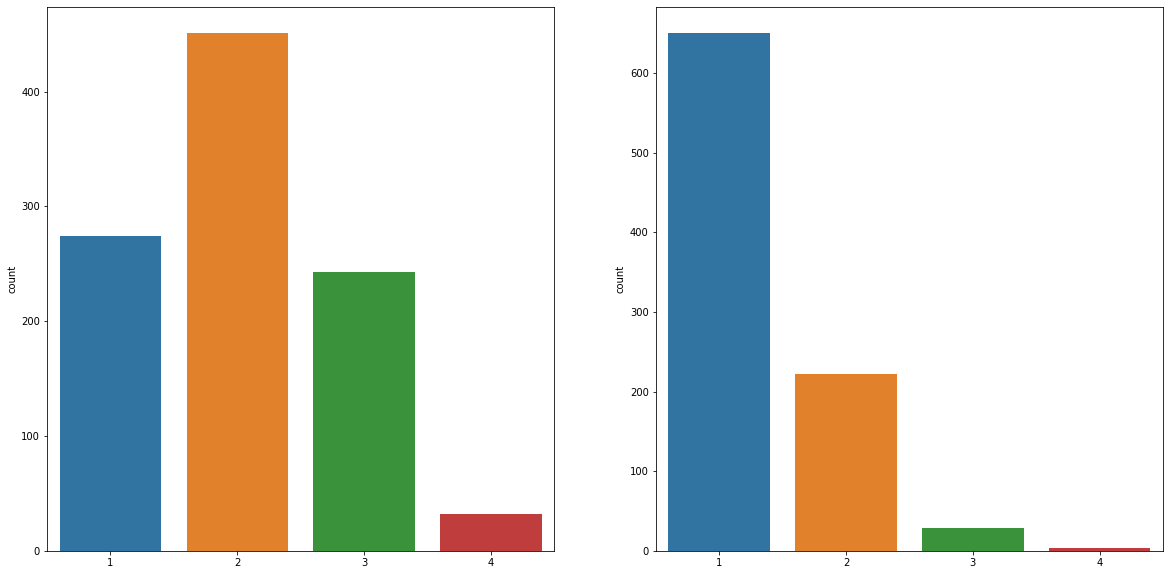

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(ax = ax[0], x=supports)
sns.countplot(ax = ax[1], x=supports_sr)

In [14]:
unique, count = np.unique(supports, return_counts=True)
unique_sr, count_sr = np.unique(supports_sr, return_counts=True)

In [15]:
count_support = dict(zip(unique, count))
count_support_sr = dict(zip(unique_sr, count_sr))

In [16]:
count_support

{1: 274, 2: 451, 3: 243, 4: 32}

In [17]:
count_support_sr

{1: 650, 2: 222, 3: 29, 4: 4}